# 5.1 二维卷积层

## 5.1.1 二维互相关运算

虽然卷积层得名于卷积（convolution）运算，但我们通常在卷积层中使用更加直观的互相关（cross-correlation）运算。在二维卷积层中，一个二维输入数组和一个二维核（kernel）数组通过互相关运算输出一个二维数组。 我们用一个具体例子来解释二维互相关运算的含义。如图5.1所示，输入是一个高和宽均为3的二维数组。我们将该数组的形状记为3×3或（3，3）。核数组的高和宽分别为2。该数组在卷积计算中又称卷积核或过滤器（filter）。卷积核窗口（又称卷积窗口）的形状取决于卷积核的高和宽，即2×2。图5.1中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：0×0+1×1+3×2+4×3=19。

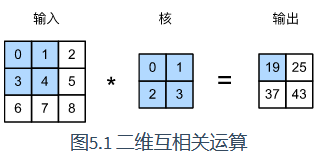

在二维互相关运算中，卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当卷积窗口滑动到某一位置时，窗口中的输入子数组与核数组按元素相乘并求和，得到输出数组中相应位置的元素。图5.1中的输出数组高和宽分别为2，其中的4个元素由二维互相关运算得出：

0×0+1×1+3×2+4×3=19,

1×0+2×1+4×2+5×3=25,

3×0+4×1+6×2+7×3=37,

4×0+5×1+7×2+8×3=43.

参考文档：file:///C:/Users/qianxun/AppData/Local/Temp/CNN%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.html
       
file:///C:/Users/qianxun/AppData/Local/Temp/CNN%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%9F%BA%E6%9C%AC%E5%8E%9F%E7%90%86.html

In [16]:
#corr2d函数，接受输入数组X与核数组K，并输出数组Y,即定义卷积运算

import torch
from torch import nn

def corr2d(X,K):
    h,w=K.shape#卷积核大小
    Y=torch.zeros(X.shape[0]-h+1,X.shape[1]-w+1)#输出数组的大小
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()#注意！不是矩阵乘法
    return Y

In [17]:
X=torch.tensor([[0,1,2],[3,4,5],[6,7,8]])
K=torch.tensor([[0,1],[2,3]])

corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

## 5.1.2 二维卷积层

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。卷积层的模型参数包括了卷积核和标量偏差。在训练模型的时候，通常我们先对卷积核随机初始化，然后不断迭代卷积核和偏差。

In [11]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super(Conv2D,self).__init__()
        #模型参数
        self.weight=nn.Parameter(torch.randn(kernel_size))
        self.bias=nn.Parameter(torch.randn(1))
    
    #前向计算函数
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias#调用卷积运算加上偏差
    

卷积窗口形状为$p×q$的卷积层称为$p×q$卷积层。同样，$p×q$卷积或$p×q$卷积核说明卷积核的高和宽分别为$p$和$q$.

## 5.1.3 图像中物体边缘检测

一个卷积层的简单应用：检测图像中物体的边缘，即找到像素变化的位置。首先我们构造一张$6×8$的图像（即高和宽分别为6像素和8像素的图像）。它中间4列为黑（0），其余为白（1）。

In [21]:
X=torch.ones(6,8)
X[:,2:6]=0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

然后我们构造一个高和宽分别为1和2的卷积核K。当它与输入做互相关运算时，如果横向相邻元素相同，输出为0；否则输出为非0。

In [22]:
K=torch.tensor([[1,-1]])

In [23]:
#将输入X和卷积核K做互相关运算。

Y=corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

## 5.1.4 通过数据学习核数组

使用物体边缘检测中的输入数据X和输出数据Y来学习我们构造的核数组K。我们首先构造一个卷积层，其卷积核将被初始化成随机数组。接下来在每一次迭代中，我们使用平方误差来比较Y和卷积层的输出，然后计算梯度来更新权重。

In [29]:
#构造一个二维卷积层
conv2d=Conv2D(kernel_size=(1,2))

step=20#迭代次数
lr=0.01
for i in range(step):
    Y_hat=conv2d(X)#进行前向计算
    loss_=((Y_hat-Y)**2).sum()
    loss_.backward()
    
    #梯度下降
    conv2d.weight.data-=lr*conv2d.weight.grad
    conv2d.bias.data-=lr*conv2d.bias.grad
    
    #梯度清零
    conv2d.weight.grad.data.zero_()
    conv2d.bias.grad.data.zero_()
#     conv2d.weight.grad.fill_(0)
#     conv2d.bias.grad.fill_(0)
    if (i+1)%5==0:
        print('Step %d, loss %.3f' % (i + 1, loss_.item()))

Step 5, loss 1.456
Step 10, loss 0.291
Step 15, loss 0.068
Step 20, loss 0.018


In [31]:
# 可以看到，学到的卷积核的权重参数与我们之前定义的核数组K较接近，而偏置参数接近0。

print("weight: ", conv2d.weight.data)
print("bias: ", conv2d.bias.data)

weight:  tensor([[ 1.0284, -1.0372]])
bias:  tensor([0.0049])


## 5.1.5 互相关运算和卷积运算

实际上，卷积运算与互相关运算类似。为了得到卷积运算的输出，我们只需将核数组左右翻转并上下翻转，再与输入数组做互相关运算。可见，卷积运算和互相关运算虽然类似，但如果它们使用相同的核数组，对于同一个输入，输出往往并不相同。

那么，你也许会好奇卷积层为何能使用互相关运算替代卷积运算。其实，在深度学习中核数组都是学出来的：卷积层无论使用互相关运算或卷积运算都不影响模型预测时的输出。为了解释这一点，假设卷积层使用互相关运算学出图5.1中的核数组。设其他条件不变，使用卷积运算学出的核数组即图5.1中的核数组按上下、左右翻转。也就是说，图5.1中的输入与学出的已翻转的核数组再做卷积运算时，依然得到图5.1中的输出。为了与大多数深度学习文献一致，如无特别说明，本书中提到的卷积运算均指互相关运算。

## 5.1.6 卷积操作和池化操作后特征图的大小计算

若图像为正方形：设输入图像尺寸为$W\times W$,卷积核尺寸为$F\times F$，步幅为S，Padding使用P，经过卷积层后输出的图像尺寸为$N\times N$：

$$N=\frac{W-F+2P}{S}+1$$

若图像为矩形：设输入图像尺寸为$W\times H$,卷积核尺寸为$F\times F$，步幅为S，图像深度(通道数)为C，Padding使用P，经过卷积层后输出的图像尺寸为$W\times H$：

$$W=\frac{W-F+2P}{S}+1$$

$$H=\frac{H-F+2P}{S}+1$$

Padding的作用用于解决图像边缘信息损失的问题。

## 5.1.6 特征图和感受野

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫特征图（feature map）。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的感受野（receptive field）。以图5.1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。

我们将图5.1中形状为2×2的输出记为$Y$，并考虑一个更深的卷积神经网络：将$Y$与另一个形状为$2×2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。